In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import os

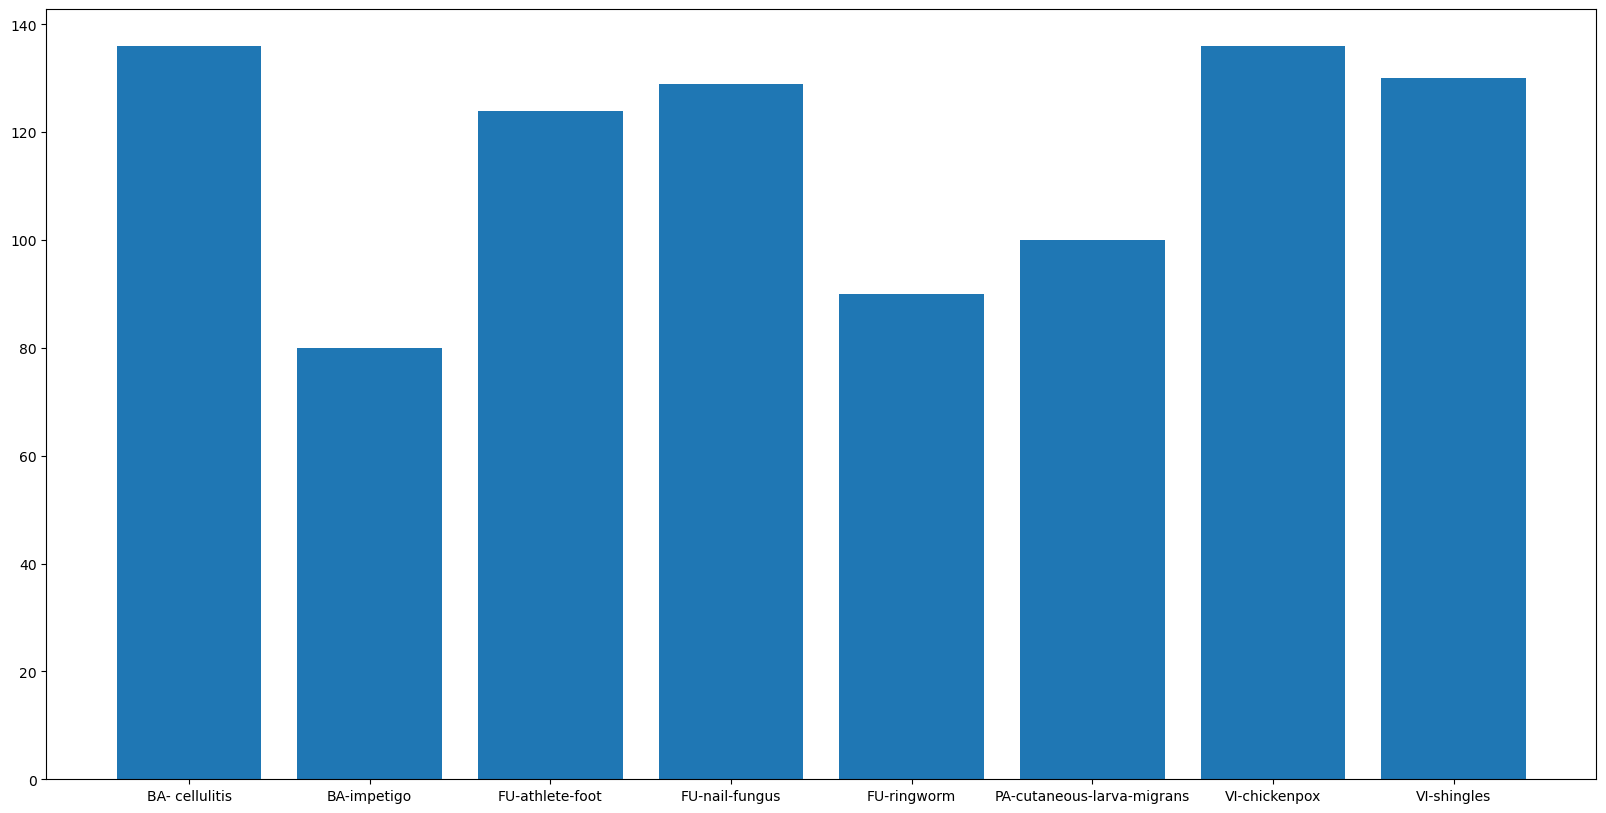

In [2]:
dir = "/Users/haziq/Desktop/skin-disease-dataset/train_set/"
    
categories = ["BA- cellulitis", 
              "BA-impetigo",
              "FU-athlete-foot",
              "FU-nail-fungus",
              "FU-ringworm",
              "PA-cutaneous-larva-migrans", 
              "VI-chickenpox", 
              "VI-shingles"]

y_heights = []

for category in categories:

    y_heights.append(len(os.listdir(dir + category)))

plt.figure(figsize=(20,10))
plt.bar(categories, y_heights)
plt.show()

In [3]:
import cv2
import numpy as np

In [4]:
training_Data = []
Display = []

sharpening_kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])

for category in categories:
    class_num = categories.index(category)
    for img in os.listdir(dir + category):
        try:
            img_array = cv2.imread(os.path.join(dir + category + "/" + img))
            new_img = cv2.resize(img_array, (224, 224))
            sharpened = cv2.filter2D(new_img, -1, sharpening_kernel)
            training_Data.append([sharpened, class_num])
        except:
            print("Error")

        

In [5]:
test_dir = "/Users/haziq/Desktop/skin-disease-dataset/test_set/"
testing_Data = []

for category in categories:
    class_num = categories.index(category)
    for img in os.listdir(test_dir + category):
        try:
            img_array = cv2.imread(os.path.join(test_dir + category + "/" + img))
            new_img = cv2.resize(img_array, (224, 224))
            sharpened = cv2.filter2D(new_img, -1, sharpening_kernel)
            testing_Data.append([sharpened, class_num])
        except:
            print("Error")


In [6]:
print(len(training_Data))

925


In [7]:
import random

random.shuffle(training_Data)

In [8]:
import numpy as np

In [9]:
input = []
labels = []

for image, label in training_Data:
    
    input.append(image)
    labels.append(label)

In [10]:
input = np.array(input)
labels = np.array(labels)

In [11]:
input = input / 255.0 #Normalizing

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models

/opt/anaconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
inputs_tensor = torch.tensor(input, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.long)

In [14]:
print(inputs_tensor.shape)
print(labels_tensor.shape)

torch.Size([925, 224, 224, 3])
torch.Size([925])


In [15]:
inputs_tensor = inputs_tensor.permute(0, 3, 1, 2) #Change shape of tensor to one which pytorch expects
print(inputs_tensor.shape)

torch.Size([925, 3, 224, 224])


In [16]:
class CustomDataset(Dataset):
    
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        x = self.inputs[index]
        y = self.labels[index]

        return x, y

In [17]:
dataset = CustomDataset(inputs_tensor, labels_tensor)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

In [18]:
model = models.mobilenet_v3_large(pretrained=True)

/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
for param in model.parameters(): #Freeze weights
    param.requires_grad = False

num_ftrs = model.classifier[3].in_features
model.classifier[3] = nn.Linear(num_ftrs, 8, bias=True) #Change neurons of final layer to match number of categories

model.classifier[3].requires_grad = True #Unfreeze final layer parameters

paramsToUpdate = list(model.classifier[3].parameters())

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(paramsToUpdate, lr=0.001)

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [22]:
def train_model(model, training_Data, criterion, optimizer, num_epochs=15):
    model.train()
    for epoch in range(num_epochs):       
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()            
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
        
    print('Training complete')

In [23]:
train_model(model, train_loader, criterion, optimizer, num_epochs=20)

Epoch [1/20], Loss: 1.1533
Epoch [2/20], Loss: 0.5607
Epoch [3/20], Loss: 0.3992
Epoch [4/20], Loss: 0.3380
Epoch [5/20], Loss: 0.2922
Epoch [6/20], Loss: 0.2733
Epoch [7/20], Loss: 0.2483
Epoch [8/20], Loss: 0.2062
Epoch [9/20], Loss: 0.2013
Epoch [10/20], Loss: 0.1539
Epoch [11/20], Loss: 0.1613
Epoch [12/20], Loss: 0.1854
Epoch [13/20], Loss: 0.1442
Epoch [14/20], Loss: 0.1629
Epoch [15/20], Loss: 0.1360
Epoch [16/20], Loss: 0.1312
Epoch [17/20], Loss: 0.1322
Epoch [18/20], Loss: 0.1390
Epoch [19/20], Loss: 0.1134
Epoch [20/20], Loss: 0.1238
Training complete


In [24]:
#Load testing tensors

inputT = []
labelT = []

for image, label in testing_Data:
    
    inputT.append(image)
    labelT.append(label)

inputT = np.array(inputT)
labelT = np.array(labelT)

inputT = inputT / 255.0

In [25]:
test_tensor = torch.tensor(inputT, dtype=torch.float32)
Ltest_tensor = torch.tensor(labelT, dtype=torch.long)

In [26]:
print(test_tensor.shape)
print(Ltest_tensor.shape)

torch.Size([234, 224, 224, 3])
torch.Size([234])


In [27]:
test_tensor = test_tensor.permute(0, 3, 1, 2)

In [28]:
test_tensor.shape

torch.Size([234, 3, 224, 224])

In [29]:
Testdataset = CustomDataset(test_tensor, Ltest_tensor)
test_loader = DataLoader(Testdataset, batch_size=1, shuffle=False) #batch size 1 to help evaluate how successfully model
                                                                    #evaluates each skin disease

In [30]:
len(Testdataset)

234

In [31]:
def evaluate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0.0
    total = 0.0
    
    catCorrect = 0.0
    catTotal = 0.0
    oldLabel = 0.0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.detach(), 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if labels == oldLabel:
                catTotal += 1
                if (predicted == labels):
                    catCorrect += 1
            else:
                print("Accuracy at predicting " + categories[oldLabel] + ": " + str((catCorrect/catTotal) * 100))
                catTotal = 1
                catCorrect = 0
                if (predicted == labels):
                    catCorrect = 1

            oldLabel = labels

        print("Accuracy at predicting " + categories[7] + ": " + str((catCorrect/catTotal) * 100))

    
    print(f'Accuracy: {100 * (correct / total):.2f}%')

In [32]:
evaluate_model(model, test_loader)

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


Accuracy at predicting BA- cellulitis: 85.29411764705883
Accuracy at predicting BA-impetigo: 100.0
Accuracy at predicting FU-athlete-foot: 96.875
Accuracy at predicting FU-nail-fungus: 100.0
Accuracy at predicting FU-ringworm: 82.6086956521739
Accuracy at predicting PA-cutaneous-larva-migrans: 92.0
Accuracy at predicting VI-chickenpox: 97.05882352941177
Accuracy at predicting VI-shingles: 100.0
Accuracy: 94.44%
